<a href="https://colab.research.google.com/github/CoderSsVartak/Image-Reconstruction/blob/master/image_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Curriculum learning algorithm:
# Train the model on easier dataset
# once satisfactory results are achieved, alter the dataset and merge the dataset with tougher examples
# Consider 12 buckets with mean as 0.1, 0.2..... and variance as 0.1 and 0.5


# About noise: Increasing the mean makes the image whiter, like effect of flash, it retains the actual shape of the face
#               Increasing the sigmoid, adds noise
# Currently on:
# Bucket 1: white noise, mean = 0.0, variance = 0.1, PSNR = 25.22, randomness added
# Bucket 2: white noise, mean = 0.0, variance = 0.05, PSNR = 31.04, randomness added
# Bucket 3: white noise, mean = 0.0, variance = 0.2, PSNR = 19.61, randomness added

# Model v4
    # epochs done = 105, optimizer = sgd with lr = 0.01, momentum = 0.2 with cosine_dist + mse loss
    # lr = [0.01, 0.005, 0.0001|| 0.01, 0.001, 0.0001, 0.0001, 0.0001, 0.00001, 0.00001, 0.00001|| 0.01, 0.001, 0.0001], 
    # momentum = [0.2, 0.6, 0.8|| 0.1, 0.4, 0.6, 0.8, 0.8, 0.8, 0.6, 0.8|| 0.2, 0.5, 0.8],
    # epochs = [70, 20, 15|| 15, 50, 15, 5, 20, 10, 20, 20||, 70, 20, 15]
    # difficulty increased after epochs [105, 155]
    # PSNR after bucket is over (train, test) [(24.46, 24.05), (25.32, 26.24)]

# Future works
# Add harder examples
# try 20 layer neural network

In [1]:
import os
import time
import random
import datetime

#Image manipulation packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

#Tensorflow models libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
#Alternative of pickle for larger files
import joblib
import pickle

#packages required to get the data uploaded on the drive
from googleapiclient.http import MediaIoBaseDownload
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from google.colab import drive
import io
import random

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
#Code to load images from Drive
def load_drive_data(file_id):

    drive_service = build('drive', 'v3')
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()

    downloaded.seek(0)
    f = joblib.load(downloaded)

    return f

#images downloaded are in the form of a dictionary, convert it to a numpy array
def dict_to_array(images):

    image_list = []
    for persons in images.keys():
        image_list.append(images[persons])
    
    return np.array(image_list)

#function to plot multiple images
def plot(images, figsize=(10, 10)):

    plt.figure(figsize=figsize)
    
    for index, image in enumerate(images):
        # display original
        ax = plt.subplot(2, len(images), index + 1)
        plt.imshow(image.reshape(image.shape[0], image.shape[1], image.shape[2]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [4]:
#images obtained are in the form of a dictionary and have values between 0-1, and are cropped so as to obtain just the facial images
#dictionary[person] = image_value

#Data description: Total facial images of 105 people with each person having a total of 6 images
image_data = load_drive_data('1QZv7mWvvF8mnT0A2mA4OFSvxF1eqPd8g')
images = dict_to_array(image_data)

In [5]:
del(image_data)
images.shape

(630, 224, 224, 3)

In [6]:
#add noise to these facial images
# Algorithm 1, Add White Noise
def add_noise(images, mean=0., sigmoid=0.3, clip=True, return_params=False, add_random=True):
    
    random = np.random.rand(images.shape[0], images.shape[1], images.shape[2], images.shape[3])
    dist = np.random.normal(loc=mean, scale=sigmoid, size=images.shape)
    
    # print(images.shape, random.shape, dist.shape)

    if add_random:
        noise = random * dist
        images_noise = images + noise

    else:
        noise = dist
        images_noise = images + dist

    if clip:
        images_noise = np.clip(images_noise, 0.0, 1.)
    
    if return_params:
        return images_noise, noise
    
    return images_noise


#Algorithm 2
#First zoom the input image and then regenerate it to create the blur effect
#The blur effect here is because of loss of pixel values during reconstruction
def zoom_blur(images, zoom_size=50, actual_size=224):

    blur_imgs = []
    for img in images:
        blur_imgs.append(cv2.resize(cv2.resize(img, (zoom_size, zoom_size)), (actual_size, actual_size)))
    
    return np.array(blur_imgs)


#find mean value of the 4 dimensional array
def find_mean(images):

    new_images = np.reshape(images, (images.shape[0]*images.shape[1]*images.shape[2]*images.shape[3]))
    return np.abs(np.mean(new_images))

#Find percent of noise in image set : Image set is 4 dimensional
#input is the noisy image and the noise that is added to the image
def find_percent(actual_images, noisy_images):

    #Find the shape of the noise, and then reshape the image to (1, batch*x*y*z) to find error
    shape = noisy_images.shape
    noisy_images = np.reshape(noisy_images, (shape[0]*shape[1]*shape[2]*shape[3], ))
    actual_images = np.reshape(actual_images, (shape[0]*shape[1]*shape[2]*shape[3]), )
    
    # Shifted the images to encounter the divison by 0 error
    noise, actual = noisy_images + 1, actual_images + 1

    #Return percentage of noise
    return np.mean(np.abs(noise -actual)/(noise))

#Tensorflow function to find psnr of an image
def psnr(y_true, y_pred):

    return tf.math.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1, name=None))

Actual Image


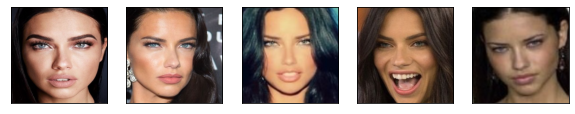

Noisy Image


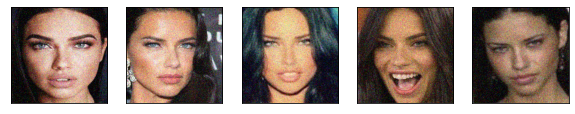

tf.Tensor(19.608526, shape=(), dtype=float32)
Precent: 5.299292784048377


In [7]:
#Visualizing the effects of blur
print("Actual Image")
plot(images[:5])

print("Noisy Image")
plot(add_noise(images[:5], mean=0., sigmoid=0.2))
print(psnr(images[: 5], add_noise(images[:5], mean=0., sigmoid=0.2)))
print("Precent:", find_percent(images[:5], add_noise(images[:5], mean=0., sigmoid=0.2))*100)

# print("Zoom Blur")
# plot(zoom_blur(images[:5], zoom_size=40))

In [8]:
#Store different sets of images in each variable and then combine them to make the training dataset

#Do not consider all the images but only a subset for memory reasons
altered_imgs = images[: 300]

# Create the input and output dataset
bucket = np.concatenate((add_noise(altered_imgs, mean=0.0, sigmoid=0.05),
                         add_noise(altered_imgs, mean=0.0, sigmoid=0.1),
                         add_noise(images[: 500], mean=0., sigmoid=0.2)))

bucket_op = np.concatenate((altered_imgs, altered_imgs, images[: 500]))

#For further stages
# bucket2 = add_noise(images, mean=0.0, sigmoid=0.5, return_params=True)
# bucket3 = add_noise(images, mean=0.0, sigmoid=0.5, return_params=True)


print("Bucket Filled", bucket.shape, bucket_op.shape)

Bucket Filled (1100, 224, 224, 3) (1100, 224, 224, 3)


In [9]:
print("Bucket Data")
print(find_percent(bucket_op, bucket)*100)
print(psnr(bucket_op, bucket))

Bucket Data
3.5434405342010216
tf.Tensor(24.162575, shape=(), dtype=float32)


In [10]:
#Combined these noisy images to make the input images and the actual images as the output images
# bucket = np.concatenate((bucket1, bucket2))
# bucket_op = np.concatenate((images, images))

noisy_images = bucket
clear_images = bucket_op

In [11]:
# gaussian_blur.shape, normal_blur.shape, noisy_images.shape, clear_images.shape
noisy_images.shape, clear_images.shape

((1100, 224, 224, 3), (1100, 224, 224, 3))

In [12]:
#To clear memory

del(bucket)
del(bucket_op)
del(altered_imgs)

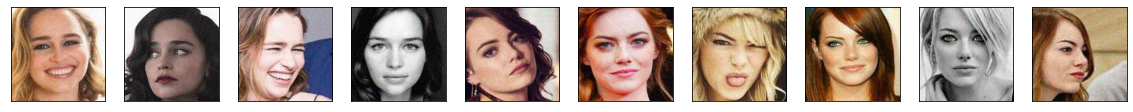

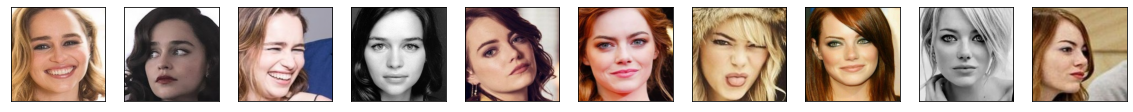

tf.Tensor(24.162575, shape=(), dtype=float32)


In [13]:
plot(noisy_images[500: 510], figsize=(20,20))
plot(clear_images[500: 510], figsize=(20,20))
print(psnr(clear_images, noisy_images))

In [14]:
def create_model():

    input_img = Input(shape=(224, 224, 3), dtype='float32')
    
    #1st Convolution Layer with Batch Normalization
    x = Conv2D(64, (9, 9), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    
    #2nd Convolution Layer without Batch Normalization
    x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    
    #3rd Conv Layer
    x = Conv2D(3, (5, 5), activation='relu', padding='same')(x)
    
    model = Model(input_img, x)
    
    return model

In [15]:
model = create_model()

In [16]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      15616     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 3)       2403      
Total params: 20,355
Trainable params: 20,227
Non-trainable params: 128
_________________________________________________________________


In [17]:
model_path = '/Image_Denoising_v4.1.h5'
model.load_weights(model_path)

In [18]:
#Training Phase: input = train_noisy, output = train_clear
#Test Phase: input = test_noisy, output = test_clear
train_noisy, test_noisy, train_clear, test_clear = train_test_split(noisy_images, clear_images, test_size=0.2)


# To save ram
# del(noisy_images)
# del(clear_images)

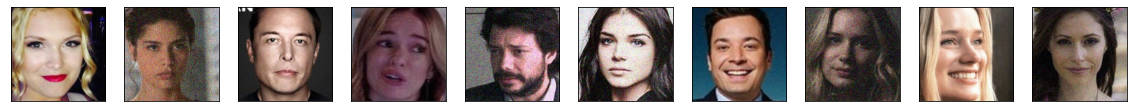

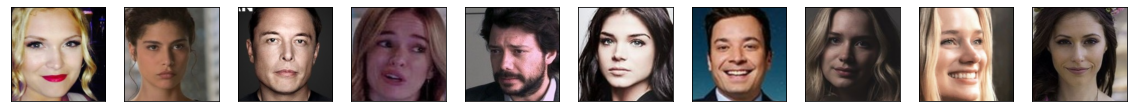

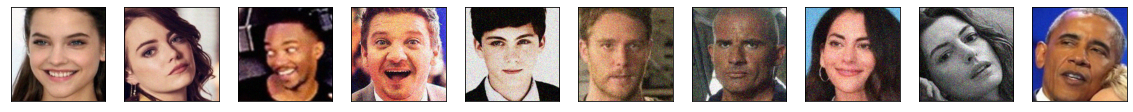

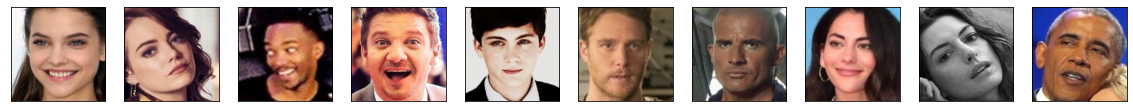

(880, 224, 224, 3) (220, 224, 224, 3)


In [19]:
plot(train_noisy[:10], figsize=(20, 20))
plot(train_clear[:10], figsize=(20, 20))
plot(test_noisy[:10], figsize=(20, 20))
plot(test_clear[:10], figsize=(20, 20))

print(train_noisy.shape, test_noisy.shape)

In [20]:
def cosine_dist(y_true, y_pred):
    return tf.reduce_mean(tf.abs(tf.losses.cosine_similarity(y_true, y_pred)))

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.losses.mean_squared_error(y_true, y_pred))

def model_loss(y_true, y_pred):
    return tf.reduce_mean(tf.losses.mean_squared_error(y_true, y_pred) + (1 - cosine_dist(y_true, y_pred)))

In [182]:
# Code to save logs

# Model is the tensorflow/keras model
# history is the dictionary returned after model training
# logs are stored as a dictionary with key as the model_name, date and time
# Buket number is string
def save(model=None, history=None, name="Image_Denoising_v4.1.h5", bucket_num=None, logs=None, save_logs=False):

    if model and name:
        model.save(name)
        print("Model Saved")
    elif model:
        model.save("Image_Denoising.h5")
        print("Model Saved")
    
    if history:
        logs[f'Bucket{bucket_num}_logs_{datetime.datetime.now()}'] = history.history
        print("History Saved in logs")
    if save_logs:
        with open('log_file.pickle', 'ab') as file:
            pickle.dump({'logs': logs}, file)
        print("Logs Saved and are ready to be downloaded")
    return True

#Load the logfile
def load(model=None, model_name=None, logfile_name=None):

    if model and model_name:
        model.load(model_name)
        print("model loaded")
    if logfile_name:
        with open(logfile_name, 'rb') as file:
            temp_logs = pickle.load(file)

        print("Log file loaded in the form of a dictionary")

        return temp_logs['logs']

    return True

In [144]:
# to load logfile
logs = {}
logs = load(logfile_name='/log_file.pickle')
print(logs.keys())

Log file loaded in the form of a dictionary
dict_keys(['Bucket3_logs_2020-12-12 12:22:43.155831', 'Bucket3_logs_2020-12-12 12:24:46.133016'])


In [197]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.0001, momentum=0.8, nesterov=False, name="SGD"
)
loss = model_loss
metrics = [psnr, mse]
epochs = 15
batch_size = 32

In [198]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history = model.fit(train_noisy, train_clear, validation_data=(test_noisy, test_clear), epochs=epochs, batch_size=batch_size)

Epoch 1/15
28/28 [==============================] - 325s 12s/step - loss: 0.0103 - psnr: 26.2504 - mse: 0.0026 - val_loss: 0.0084 - val_psnr: 27.5910 - val_mse: 0.0020
Epoch 2/15
28/28 [==============================] - 323s 12s/step - loss: 0.0094 - psnr: 26.7703 - mse: 0.0024 - val_loss: 0.0084 - val_psnr: 27.6345 - val_mse: 0.0019
Epoch 3/15
28/28 [==============================] - 321s 11s/step - loss: 0.0103 - psnr: 26.2927 - mse: 0.0027 - val_loss: 0.0084 - val_psnr: 27.6251 - val_mse: 0.0020
Epoch 4/15
28/28 [==============================] - 322s 11s/step - loss: 0.0098 - psnr: 26.4468 - mse: 0.0025 - val_loss: 0.0084 - val_psnr: 27.6310 - val_mse: 0.0019
Epoch 5/15
11/28 [==========>...................] - ETA: 3:00 - loss: 0.0108 - psnr: 26.4761 - mse: 0.0025

In [150]:
# after the model is trained save the model and the log file
save(model=model, history=history, name='Image_Denoising_v4.2.h5', bucket_num="3", logs=logs, save_logs=True)
print("Saved keys are ", logs.keys())

History Saved in logs
Logs Saved and are ready to be downloaded
Saved keys are  dict_keys(['Bucket3_logs_2020-12-12 12:22:43.155831', 'Bucket3_logs_2020-12-12 12:24:46.133016', 'BucketNone_logs_2020-12-12 14:54:01.130133'])


In [181]:
logs.keys()

{'logs': {'Bucket3_logs_2020-12-12 12:24:46.133016': {'loss': [0.018425146117806435, 0.0178749468177557, 0.01765846274793148, 0.017079636454582214, 0.017162980511784554, 0.017115971073508263, 0.016768446192145348, 0.015999523922801018, 0.015647605061531067, 0.015730740502476692, 0.01550961472094059, 0.01601000316441059, 0.015035214833915234, 0.014471192844212055, 0.014679860323667526, 0.014712544158101082, 0.014700538478791714, 0.013941776007413864, 0.013859393075108528, 0.014171496964991093, 0.013483076356351376, 0.013304831460118294, 0.013336357660591602, 0.013935677707195282, 0.013523158617317677, 0.013966083526611328, 0.0138083565980196, 0.013677019625902176, 0.01325276680290699, 0.013531753793358803, 0.015064455568790436, 0.01283625140786171, 0.01242175791412592, 0.012606185860931873, 0.013327146880328655, 0.012478437274694443, 0.012253466062247753, 0.013651004992425442, 0.011949597857892513, 0.012268316932022572, 0.012525445781648159, 0.01221772562712431, 0.01172137726098299, 0.0

dict_keys(['Bucket3_logs_2020-12-12 12:24:46.133016', 'Bucket3_logs_2020-12-12 14:54:01.130133'])

Input Images


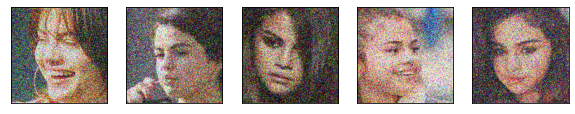

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model's Output


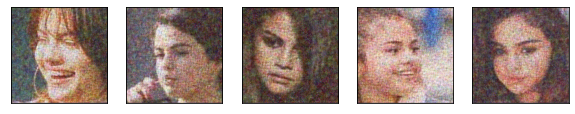


Actual Clear Image


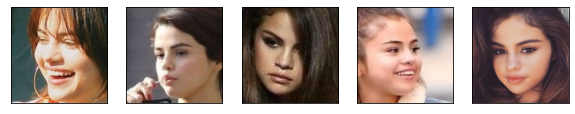

PSNR: 17.975719451904297
Noisy Image PSNR: 10.490087509155273

Cosine Distance from actual image: 0.9828757047653198
Cosine Distance from Noisy Image: 0.8315314650535583

Mean of Noisy Images: 0.4451521933078766
Mean of Predicted Images: 0.459506630897522
Mean of Actual Images: 0.4268663823604584

Mean error noisy image: 0.08933483809232712
Mean error pred image: 0.01606348529458046

Percentage of Noise:  15.781955420970917 %
Percentage of Noise in prediction:  7.078453898429871 %


In [191]:
 #Visualize the models predictions and also the time constraints
count = 5
figsize = (10, 10)

#Input & Output Images

# Easier/ Same level as training
# Same distribution as training phase
# start = random.randint(0, test_noisy.shape[0])
# ip_imgs = test_noisy[start: start+count]
# actual_imgs = test_clear[start: start+count]

#Tougher images
# Using clear images to generate noisy images, same process as the one used to generate training images
# Previously unseen dataset
start = random.randint(500, 630)
ip_imgs, noise = add_noise(images[start: start+count], mean=0., sigmoid=0.8, return_params=True)
actual_imgs = images[start: start+count]



#make prediction on a noisy image, generate an output and plot it
pred_img = model.predict(ip_imgs)

# Converted the datatype to float32 for cosine_dist function to work: required
actual_imgs = actual_imgs.astype('float32')
ip_imgs = ip_imgs.astype('float32')
pred_img = pred_img.astype('float32')

# Plot input images
print("Input Images")
plot(ip_imgs, figsize=figsize)

# Plot predicted images
print("Model's Output")
plot(pred_img, figsize=figsize)

# Plot actual images
print("\nActual Clear Image")
plot(actual_imgs, figsize=figsize)



#Print metrics
print(f'PSNR: {psnr(actual_imgs, pred_img)}\nNoisy Image PSNR: {psnr(actual_imgs, ip_imgs)}')
print(f'\nCosine Distance from actual image: {cosine_dist(actual_imgs, pred_img)}\nCosine Distance from Noisy Image: {cosine_dist(actual_imgs, ip_imgs)}')
print(f'\nMean of Noisy Images: {find_mean(ip_imgs)}\nMean of Predicted Images: {find_mean(pred_img)}\nMean of Actual Images: {find_mean(actual_imgs)}')
print(f'\nMean error noisy image: {mse(actual_imgs, ip_imgs)}\nMean error pred image: {mse(actual_imgs, pred_img)}')
print("\nPercentage of Noise: ", find_percent(actual_imgs, ip_imgs)*100, "%")
print("Percentage of Noise in prediction: ", find_percent(actual_imgs, pred_img)*100, "%")


In [187]:
#To extract logs from the log dictionary

# print("Available Keys => ", logs.keys())
# key_name = input("Enter key name  ")
# new_history = logs[key_name]


# If logs are not downloaded from the logfile, then run this line of code
new_history = history.history

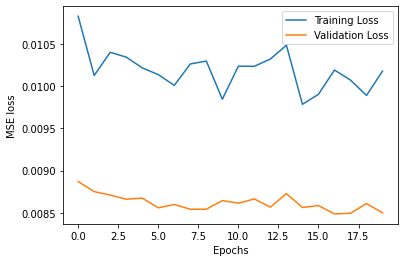

In [188]:
plt.plot(new_history['loss'], label='Training Loss')
plt.plot(new_history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend()
plt.show()

In [195]:
sim_model = VGG19(include_top=False, weights='imagenet')

80142336/80134624 [==============================] - 1s 0us/step


In [196]:
tf.reduce_sum(sim_model.predict(pred_img)), tf.reduce_sum(sim_model.predict(ip_imgs)), tf.reduce_sum(sim_model.predict(actual_imgs))

(<tf.Tensor: shape=(), dtype=float32, numpy=20868.75>,
 <tf.Tensor: shape=(), dtype=float32, numpy=19739.203>,
 <tf.Tensor: shape=(), dtype=float32, numpy=22845.16>)

In [192]:
find_mean(test_noisy)-find_mean(test_clear), find_mean(train_noisy)-find_mean(train_clear)

(0.0014520268853378537, 0.00126635421177268)

In [193]:
find_percent(test_clear, test_noisy), find_percent(train_clear, train_noisy) 

(0.03506243627866522, 0.03552739760784652)